Attempt to classify interacting and non-interacting protein pairs based on their embeddings:

In [1]:
import numpy as np
import pandas as pd
import json
from pathlib import Path
from tqdm import tqdm

In [2]:
OUTPUT_DIR = Path("outputs")

Load embeddings:

In [3]:
def load_samples_in_chunks(input_dir, block, batch_size=2, emb_type="single_embeddings", transforms=None):
    def load_sample(name):
        embeddings = np.load(input_dir / name / "seed-0_embeddings" / (name + "_seed-0_embeddings.npz"))
        label = int(name.split("_")[-1])
        return embeddings[emb_type], label

    sample_names = [d.name for d in input_dir.iterdir() if d.is_dir() and d.name.startswith(block)]
    for i in range(0, len(sample_names), batch_size):
        out = []
        labels = []
        for j in range(batch_size):
            repr, label = load_sample(sample_names[i+j])
            if transforms is None:
                out.append(repr)
                labels.append(label)
                continue
            transform_outputs = []
            for transform in transforms:
                transform_outputs.append(transform(repr))
            if len(transforms) == 1:
                out.extend(transform_outputs)
            else:
                out.append(transform_outputs)
            labels.append(label)
                
        out = np.asarray(out)
        yield out, labels

def load_block(input_dir, block, emb_type="single_embeddings", transforms=None):
    X = []
    y = []
    for sample, labels in load_samples_in_chunks(input_dir, block, emb_type=emb_type, transforms=transforms):
        X.append(sample)
        y.extend(labels)
    
    X = np.concatenate(X, axis=0)
    y = np.array(y)
    return X, y

In [12]:
X_train, y_train = load_block(OUTPUT_DIR, "p0", transforms=[lambda x: np.mean(x, axis=0), lambda x: np.max(x, axis=0)])
X_val, y_val = load_block(OUTPUT_DIR, "p1", transforms=[lambda x: np.mean(x, axis=0), lambda x: np.max(x, axis=0)])
X_test, y_test = load_block(OUTPUT_DIR, "p2", transforms=[lambda x: np.mean(x, axis=0), lambda x: np.max(x, axis=0)])

In [26]:
X_test, y_test = load_block(Path("test"), "p2", emb_type="pair_embeddings", transforms=[lambda x: np.mean(x, axis=(0, 1)), lambda x: np.max(x, axis=(0, 1))])

In [13]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape

((1500, 2, 384), (500, 2, 384), (500, 2, 384), (1500,))

In [30]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from collections import defaultdict
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
import time

def hpm_search(X_train, y_train, X_val, y_val):
    param_grid = [
        {
            'logisticregression__solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
            'logisticregression__penalty': ['l2'],
            'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]
        },
        {
            'logisticregression__solver': ['liblinear', 'saga'],
            'logisticregression__penalty': ['l1'],
            'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]
        }
    ]
    
    model = make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=1000)
    )

    # Grid search
    grid_search = GridSearchCV(model, param_grid, cv=[(list(range(len(X_train))), list(range(len(X_train), len(X_train)+len(X_val))))], scoring='accuracy')
    grid_search.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))

    return grid_search.best_estimator_, grid_search.best_params_

def test_pooling_transforms(transforms):
    results = {}
    for repr in transforms:
        print(f"Loading {repr}")
        start_load = time.time()
        X_train, y_train = load_block(OUTPUT_DIR, "p0", transforms=transforms[repr], emb_type=repr)
        X_val, y_val = load_block(OUTPUT_DIR, "p1", transforms=transforms[repr], emb_type=repr)
        load_time = time.time() - start_load
        print(f"Took {load_time:.1f}s to load")
        print()
        
        results[repr] = defaultdict(list)
        for i in range(len(transforms[repr])):
            start_opt = time.time()
            estimator, params = hpm_search(X_train[:, i, :], y_train, X_val[:, i, :], y_val)
            opt_time = time.time() - start_opt
            
            # Predict on validation set
            y_pred = estimator.predict(X_val[:, i, :])
            y_proba = estimator.predict_proba(X_val[:, i, :])[:, 1]  # probs for positive class

            # Calculate metrics
            acc = accuracy_score(y_val, y_pred)
            roc_auc = roc_auc_score(y_val, y_proba)
            pr_auc = average_precision_score(y_val, y_proba)

            results[repr]["best_estimator"].append(estimator)
            results[repr]["best_params"].append(params)
            results[repr]["val_accuracy"].append(acc)
            results[repr]["val_roc_auc"].append(roc_auc)
            results[repr]["val_pr_auc"].append(pr_auc)
            results[repr]["load_time"].append(load_time)
            results[repr]["opt_time"].append(opt_time)

            # Log info
            print(f"#### {repr} Transform {i} - {opt_time:.1f} s")
            print(f"Best parameters: {params}")
            print(f"Accuracy: {acc}")
            print(f"ROC AUC: {roc_auc}")
            print(f"PR AUC: {pr_auc}")
            print()

    return results

In [ ]:
test_transforms = {
    "single_embeddings": [
        lambda x: np.mean(x, axis=0),
        lambda x: np.max(x, axis=0),
        lambda x: np.min(x, axis=0)
    ],
    "pair_embeddings": [
        lambda x: np.mean(x, axis=(0, 1)),
        lambda x: np.max(x, axis=(0, 1)),
        lambda x: np.min(x, axis=(0, 1))
    ]
}

import warnings
warnings.filterwarnings("ignore")

opt_results = test_pooling_transforms(test_transforms)

Loading single_embeddings
Took 14.1s to load

#### single_embeddings Transform 0 - 46.1 s
Best parameters: {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}
Accuracy: 0.818
ROC AUC: 0.9077599999999998
PR AUC: 0.9168571221241814

#### single_embeddings Transform 1 - 37.1 s
Best parameters: {'logisticregression__C': 0.001, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}
Accuracy: 0.778
ROC AUC: 0.8757919999999999
PR AUC: 0.8655326487801306

#### single_embeddings Transform 2 - 38.7 s
Best parameters: {'logisticregression__C': 0.001, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}
Accuracy: 0.766
ROC AUC: 0.8693440000000001
PR AUC: 0.8584625064076106

Loading pair_embeddings


In [ ]:
import pickle as pkl

with open("opt_results.pkl", "wb") as file:
    pkl.dump(opt_results, file)

In [4]:
import pickle as pkl

with open("opt_results.pkl", "rb") as file:
    opt_results = pkl.load(file)

Convert the results of the parameter optimization to a table for easy visualization:

In [5]:
def optresults2table(results):
    dfs = []
    for repr in results:
        params_df = pd.DataFrame(results[repr]["best_params"])
        params_df.columns = [col.replace("logisticregression__", "") for col in params_df.columns]
    
        rest_data = pd.DataFrame({k: v for k, v in results[repr].items() if k != "best_estimator" and k != "best_params"})
        df = pd.concat([params_df, rest_data], axis=1)
        df["representation"] = repr
        df = df[["representation"] + [col for col in df.columns if col != "representation"]]
        dfs.append(df)
        
    final_df = pd.concat(dfs, axis=0)
    return final_df

In [6]:
results = optresults2table(opt_results)

In [8]:
results

,representation,C,penalty,solver,val_accuracy,val_roc_auc,val_pr_auc,load_time,opt_time
0,single_embeddings,0.010,l2,lbfgs,0.818,0.907760,0.916857,14.125211,46.132642
1,single_embeddings,0.001,l2,lbfgs,0.778,0.875792,0.865533,14.125211,37.111000
2,single_embeddings,0.001,l2,lbfgs,0.766,0.869344,0.858463,14.125211,38.673072
0,pair_embeddings,10.000,l2,saga,0.806,0.877216,0.880036,4592.900167,19.305557
1,pair_embeddings,0.001,l2,lbfgs,0.706,0.786128,0.803313,4592.900167,5.898880
2,pair_embeddings,0.001,l2,lbfgs,0.720,0.801328,0.807100,4592.900167,9.578075


The best performant model is the logistic regression trained on single embeddings with global average pooling.

Check the performance on the test set:

In [9]:
X_test, y_test = load_block(OUTPUT_DIR, "p2", transforms=[lambda x: np.mean(x, axis=0)])

In [10]:
model = opt_results["single_embeddings"]["best_estimator"][0]

In [16]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, average_precision_score
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob[:, 1])}")
print(f"PR AUC: {average_precision_score(y_test, y_prob[:, 1])}")

Accuracy: 0.84
Precision: 0.842741935483871
Recall: 0.836
ROC AUC: 0.904464
PR AUC: 0.9298102586658006


Plot the precision-recall curve:

In [79]:
np.savez_compressed("results/test_pred.npz", y_test=y_test, y_prob=y_prob, y_pred=y_pred)

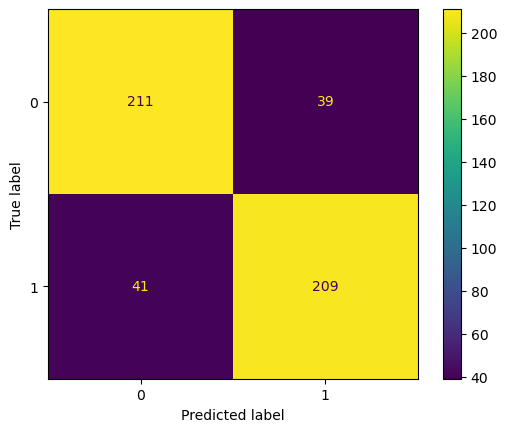

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

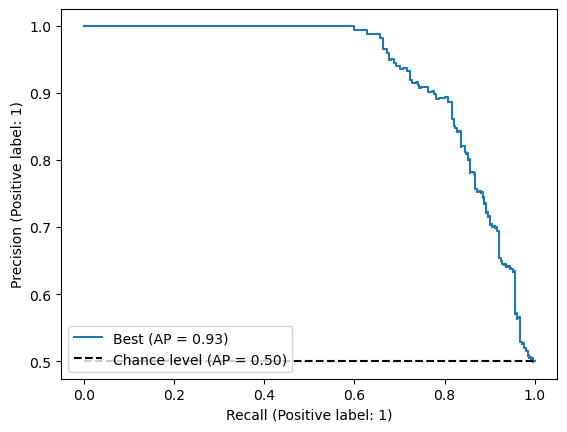

In [21]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name="Best", plot_chance_level=True)


# Visualize difference in representations between real and false PPIs

In [22]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_test)

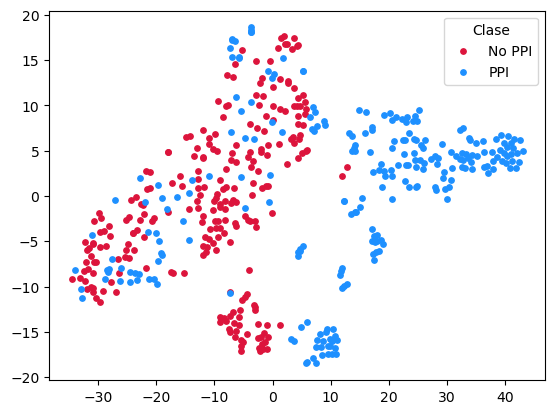

In [43]:
X_tsne0 = X_tsne[y_test == 0]
X_tsne1 = X_tsne[y_test == 1]

plt.scatter(X_tsne0[:, 0], X_tsne0[:, 1], c="crimson", s=15, label="No PPI")
plt.scatter(X_tsne1[:, 0], X_tsne1[:, 1], c="dodgerblue", s=15, label="PPI")

plt.legend(title="Clase")
plt.show()

In [49]:
X_train, y_train = load_block(OUTPUT_DIR, "p0", transforms=[lambda x: np.mean(x, axis=0)])
X_val, y_val = load_block(OUTPUT_DIR, "p1", transforms=[lambda x: np.mean(x, axis=0)])
X_test, y_test = load_block(OUTPUT_DIR, "p2", transforms=[lambda x: np.mean(x, axis=0)])

In [111]:
X = np.concatenate((X_train, X_val, X_test), axis=0)
y = np.concatenate((y_train, y_val, y_test), axis=0)
X.shape, y.shape

((2500, 384), (2500,))

In [112]:
st = StandardScaler()
X_std = st.fit_transform(X)

In [113]:
X_random = np.random.randn(*X_std.shape)

In [114]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_std)

In [115]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_random_tsne = tsne.fit_transform(X_random)

In [116]:
np.savez_compressed("results/tsne.npz", X_tsne=X_tsne, X_random_tsne=X_random_tsne, y=y)

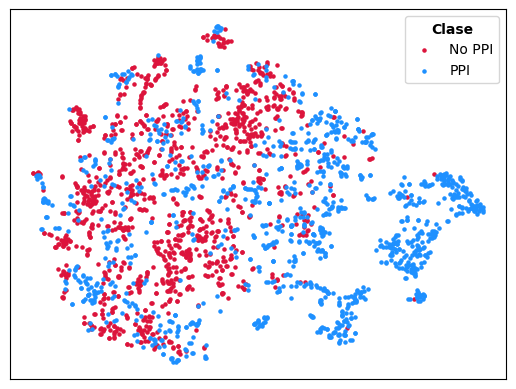

In [104]:
X_tsne0 = X_tsne[y == 0]
X_tsne1 = X_tsne[y == 1]

plt.scatter(X_tsne0[:, 0], X_tsne0[:, 1], c="crimson", s=5, label="No PPI")
plt.scatter(X_tsne1[:, 0], X_tsne1[:, 1], c="dodgerblue", s=5, label="PPI")

plt.legend(title="Clase", title_fontproperties={"weight": "bold"})
plt.xticks([])
plt.yticks([])
plt.show()

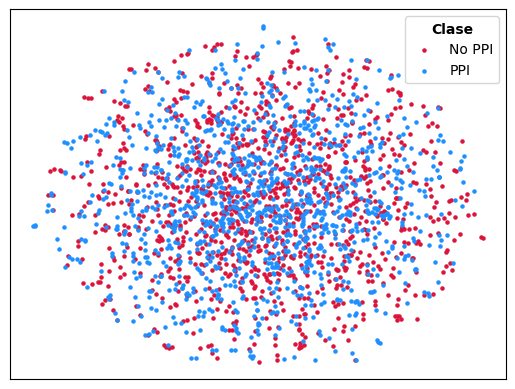

In [118]:
X_random_tsne0 = X_random_tsne[y == 0]
X_random_tsne1 = X_random_tsne[y == 1]

plt.scatter(X_random_tsne0[:, 0], X_random_tsne0[:, 1], c="crimson", s=5, label="No PPI")
plt.scatter(X_random_tsne1[:, 0], X_random_tsne1[:, 1], c="dodgerblue", s=5, label="PPI")

plt.legend(title="Clase", title_fontproperties={"weight": "bold"})
plt.xticks([])
plt.yticks([])
plt.show()